# Log interpolation between wells

## Implementation in bruges

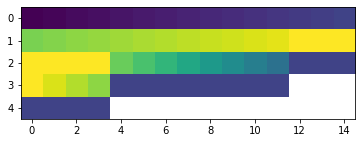

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import bruges as bg

a = np.array([2,6,7,7,3])
b = np.array([3,7,3])
dists = (10,)
panel = bg.models.panel(a, b, num=15, dists=dists)

plt.imshow(panel)

---

## Development

Make two 1D arrays of made-up data.

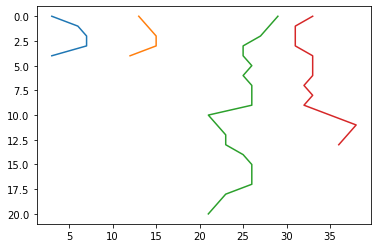

In [27]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array([3,6,7,8,5,4,5,4,5,4,5,6,6,6,6,6,6,3,2,3])
b = np.array([6,7,8,5,2,3,2,3,3,3,1,1,1,3,])
c = np.array([9,8,7,5,5,6,5,6,6,6,1,2,3,3,5,6,6,6,3,2,1])
d = np.array([6,7,8,5,2,3,2,3,3,3,1,1,1,3,])[::-1]

a = np.array([3,6,7,7,3])
b = np.array([3,4,5,5,2])

# ALL SAME LENGTH
# a = np.array([3,6,7,8,5,4,5,4,5,4,5,6,6,6,])
# b = np.array([6,7,8,5,2,3,2,3,3,3,1,1,1,3,])
# c = np.array([9,8,7,5,5,6,5,6,6,6,1,2,3,3,])

plt.plot(a, np.arange(a.size))
plt.plot(b + 10, np.arange(b.size))
plt.plot(c + 20, np.arange(c.size))
plt.plot(d + 30, np.arange(d.size))
plt.gca().invert_yaxis()

## Interpolate alike

That is, interpolate between two 1D arrays **of equal length**. The `interpolate_alike` function is the fundamental bit, in terms of the interpolation. The rest of the code deals with the lengths of things.

In [28]:
from scipy.ndimage import zoom

def reconcile(*arrays, order=0):
    """
    Make sure 1D arrays are the same length.
    If not, stretch them to match the longest.
    """
    maxl = max(len(arr) for arr in arrays)
    out = []
    for arr in arrays:
        if len(arr) < maxl:
            out.append(zoom(arr, zoom=maxl/len(arr), order=order))
        else:
            out.append(arr)
    return tuple(out)

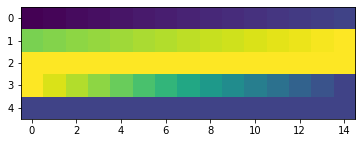

In [63]:
from scipy.interpolate import interp1d

def interpolate_alike(*arrays, num=50, dists=None, kind='linear'):
    """
    Linear interpolation between 1D arrays of the
    same length.

    Args:
        num (int): The number of steps to take, so will be
            the width (number of cols) of the output
            array.
        dists (array-like): A list or tuple or array of the
            distances (any units) between the arrays in
            the real world.
        kind (str): Will be passed to scipy.interpolate.interp1d,
            which does the lateral interpolation between samples.

    Returns:
        ndarray. The result, with `num` columns. The number
            of rows is the same as the longest input.
    """
    intervals = len(arrays) - 1
    if dists is None:
        dists = intervals * [num / intervals]
    x = np.hstack([[0], np.cumsum(dists)])
    f = interp1d(x, np.stack(arrays), axis=0, kind=kind)
    return f(np.linspace(x[0], x[-1], num=num)).T


a = np.array([2,6,7,7,3])
b = np.array([3,7,3])

rec = reconcile(a, b, order=0)
sizes = (1, 0.5)
dists = (10,)
interp = interpolate_alike(*rec, dists=dists, num=15)

plt.imshow(interp)

## Stretch to any proportions

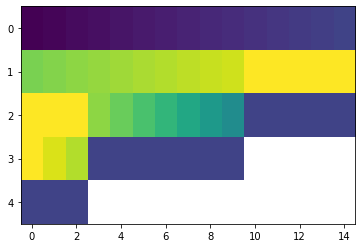

In [65]:
def unreconcile(arr, sizes, dists=None, order=0):
    """
    Opposite of reconcile.
    
    sizes (int): The relative lengths of the profiles
        in the array. Default returns the input array.
    dists (array-like): The relative distances between
        the profiles in the array. Sum used to calculate
        the output width in pixels if the width argument
        is None. If not given, the distances are assumed
        to be equal.
    order (int): The order of the spline interpolation,
        from 0 to 3. The default is 0, which gives
        nearest neighbour interpolation. 1 gives linear
        interpolation, etc. Use 0 for ints and 1-3 for
        floats.
    """
    if np.all(sizes[0] == np.array(sizes)):
        # Nothing to do.
        return arr

    intervals = len(sizes) - 1

    if dists is None:
        eq = arr.shape[-1] // intervals
        dists = [eq] * intervals
    assert len(dists) == intervals
    
    maxlen = int(np.ceil(max(sizes) * arr.shape[0]))
    
    dist_ = np.cumsum(dists)
    idx = arr.shape[-1] * dist_ / max(dist_)
    chunks = np.split(arr, idx[:-1].astype(int), axis=-1)

    zoomed = []
    for left, right, chunk in zip(sizes[:-1], sizes[1:], chunks):
        zooms = np.linspace(left, right, chunk.shape[-1]+1)
        for z, col in zip(zooms, chunk.T):
            new_ = zoom(col, zoom=z, order=order, mode='nearest')
            pad_width = maxlen - new_.size
            new = np.pad(new_, pad_width=(0, pad_width), mode='constant', constant_values=np.nan)
            zoomed.append(new)

    return np.array(zoomed).T

panel = unreconcile(interp, sizes=sizes, dists=dists, order=0)

plt.imshow(panel, aspect='auto', interpolation='none')

In [57]:
sizes

[5, 3]

## Generate panel for arbitrary inputs

Bring it all together...

In [67]:
def interpolate(*arrays, num=50, dists=None, order=0, kind='linear'):
    """
    Interpolate an arbitrary collection of 1D arrays.
    """
    sizes = np.array([len(x) for x in arrays])
    sizes = sizes / np.max(sizes)
    rec = reconcile(*arrays)
    interp = interpolate_alike(*rec, num=num, dists=dists, kind=kind)
    panel = unreconcile(interp, sizes=sizes, dists=dists, order=order)
    return panel

a = np.array([2,6,7,7,3])
b = np.array([3,7,3])
rec = reconcile(a, b, order=0)
dists = (10,)
panel = interpolate(a, b, num=15, dists=dists)
panel.shape
# plt.imshow(panel, aspect='auto', interpolation='none')

(5, 15)

In [70]:
panel[:, 7]

array([2.5, 6.5, 5. , 3. , nan])

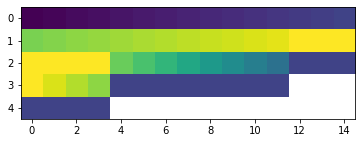

In [69]:
plt.imshow(panel)